### Importing necessary libraries:

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import numpy as np
from adjustText import adjust_text
import multiprocessing
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
import re
import string
import time
from wordcloud import WordCloud
from tqdm import tqdm
import seaborn as sns, matplotlib.pyplot as plt
import warnings
import os
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from sklearn.cluster import KMeans
import xlsxwriter
import pyLDAvis.gensim       # Plotting tools
from IPython.display import HTML

warnings.filterwarnings(action='ignore')

%matplotlib inline
tqdm.pandas()

color = sns.color_palette("Set2")
cores = multiprocessing.cpu_count()

c:\users\yogesh.k\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Reading data:

In [2]:
file_name = "data.xlsx"
xl_workbook = pd.ExcelFile(file_name)
df = xl_workbook.parse("Sheet4")

### A quick look at the data:
Firstly we will start with basic data analysis where we look at the size and other high-level features of the dataset.

In [3]:
df.shape

(141, 2)

There are two columns <font color=orange>Message</font> and <font color=orange>Intent</font>. <br>
Message column has chat conversations which comprise the ‘features’ for an ML model. <br>
Intent column is the category of classes which are the ‘target variable’ for tagging. <br>

Note: Here is what the data looks like once you cluster it using the approach discussed in this article along with some manual tagging. An intent column is given so that you can try a different approach and compare your result with an expected result.

In [4]:
pd.set_option('display.max_colwidth', -1)

## Print first 20 rows.
df.head(20)

,Message,Intent
0,"Hi there, i would like to change my delivery date if possible?",amend_change_day
1,cancel my order 974633 and refund me accordingly,amend_cancel
2,damaged package,appliance_oos
3,"evening, how do i return an item i bought online?",order_return
4,how do i add assembly included to my online order,assembly
5,delivery missing item,order_missing
6,how can i return an order?,delivery_return
7,damaged/faulty product,appliance_oos
8,my account is locked due to too many attempts at password,account_login
9,can i get an item delivered on a different date?,amend_change_day


### Data Cleaning
Usually, in the text, data cleaning is required because real-world chat conversations are full of slangs, shortcuts, emojis etc. The text data is cleaned by removing stop words(loaded from nltk library), expanding shortened words etc. <br>
I also found additional list of words from __[here](https://www.ranks.nl/stopwords)__ which can also be treated like stop words. Please thoroughly review and modify the list before using it. <br>
There are more __[preprocessing techniques](https://www.analyticsvidhya.com/blog/2016/07/practical-guide-data-preprocessing-python-scikit-learn/)__ to convert raw data into clean dataset based on the type of data set.

In [5]:
split_pattern = re.compile(r'\s+')
lemma = WordNetLemmatizer()
str_punct = string.punctuation

## load nltk's English stopwords as variable called 'stop'
stop = nltk.corpus.stopwords.words('english')
extendedStopWords = ["a", "able", "about", "above", "abst", "accordance", "I", "without", "according", "accordingly", "across", "act", "actually", "added", "adj", "affected", "affecting", "affects", "after", "afterwards", "again", "against", "ah", "all", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "apparently", "approximately", "are", "aren", "arent", "arise", "around", "as", "aside", "ask", "asking", "at", "auth", "available", "away", "awfully", "b", "back", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "between", "beyond", "biol", "both", "brief", "briefly", "but", "by", "c", "ca", "came", "can", "cannot", "can't", "cause", "causes", "certain", "certainly", "co", "com", "come", "comes", "contain", "containing", "contains", "could", "couldnt", "d", "date", "did", "didn't", "different", "do", "does", "doesn't", "doing", "done", "don't", "down", "downwards", "during", "e", "each", "ed", "edu", "effect", "eg", "eight", "eighty", "either", "else", "elsewhere", "end", "ending", "enough", "especially", "et", "et-al", "etc", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "except", "f", "far", "few", "ff", "fifth", "first", "five", "fix", "followed", "following", "follows", "for", "former", "formerly", "forth", "found", "four", "from", "further", "furthermore", "g", "gave", "get", "gets", "getting", "give", "given", "gives", "giving", "go", "goes", "gone", "got", "gotten", "h", "had", "happens", "hardly", "has", "hasn't", "have", "haven't", "having", "he", "hed", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "hereupon", "hers", "herself", "hes", "hi", "hid", "him", "himself", "his", "hither", "home", "how", "howbeit", "however", "hundred", "i", "id", "ie", "if", "i'll", "im", "immediate", "immediately", "importance", "important", "in", "inc", "indeed", "index", "information", "instead", "into", "invention", "inward", "is", "isn't", "it", "itd", "it'll", "its", "itself", "i've", "j", "just", "k", "keep", "keeps", "kept", "kg", "km", "know", "known", "knows", "l", "largely", "last", "lately", "later", "latter", "latterly", "least", "less", "lest", "let", "lets", "like", "liked", "likely", "line", "little", "'ll", "look", "looking", "looks", "ltd", "m", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "million", "miss", "ml", "more", "moreover", "most", "mostly", "mr", "mrs", "much", "mug", "must", "my", "myself", "n", "na", "name", "namely", "nay", "nd", "near", "nearly", "necessarily", "necessary", "need", "needs", "neither", "never", "nevertheless", "new", "next", "nine", "ninety", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "now", "nowhere", "o", "obtain", "obtained", "obviously", "of", "off", "often", "oh", "ok", "okay", "old", "omitted", "on", "once", "one", "ones", "only", "onto", "or", "ord", "other", "others", "otherwise", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "owing", "own", "p", "page", "pages", "part", "particular", "particularly", "past", "per", "perhaps", "placed", "please", "plus", "poorly", "possible", "possibly", "potentially", "pp", "predominantly", "present", "previously", "primarily", "probably", "promptly", "proud", "provides", "put", "q", "que", "quickly", "quite", "qv", "r", "ran", "rather", "rd", "re", "readily", "really", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "respectively", "resulted", "resulting", "results", "right", "run", "s", "said", "same", "saw", "say", "saying", "says", "sec", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sent", "seven", "several", "shall", "she", "shed", "she'll", "shes", "should", "shouldn't", "show", "showed", "shown", "showns", "shows", "significant", "significantly", "similar", "similarly", "since", "six", "slightly", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "specifically", "specified", "specify", "specifying", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure	t", "take", "taken", "taking", "tell", "tends", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'll", "theyre", "they've", "think", "this", "those", "thou", "though", "thoughh", "thousand", "throug", "through", "throughout", "thru", "thus", "til", "tip", "to", "together", "too", "took", "toward", "towards", "tried", "tries", "truly", "try", "trying", "ts", "twice", "two", "u", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "up", "upon", "ups", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "v", "value", "various", "'ve", "very", "via", "viz", "vol", "vols", "vs", "w", "want", "wants", "was", "wasnt", "way", "we", "wed", "welcome", "we'll", "went", "were", "werent", "we've", "what", "whatever", "what'll", "whats", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "whose", "why", "widely", "willing", "wish", "with", "within", "wont", "words", "world", "would", "wouldnt", "www", "x", "y", "yes", "yet", "you", "youd", "you'll", "your", "youre", "yours", "yourself", "yourselves", "you've", "z", "zero",'Heh','heh','language','know', 'wow', 'hah', 'hey','really','year', 'yeah','wtf', 'meh', 'oops', 'nah', 'yea','doesnt','dont','make', 'huh', 'mar', 'umm', 'like', 'think','right', 'duh', 'sigh', 'wheres', 'hmm', 'interesting', 'article','good','know', 'say', 'hello', 'yup','im', 'ltsarcasmgt', 'hehe', 'blah', 'nope', 'ouch', 'uh']
stop.extend(extendedStopWords) ## https://www.ranks.nl/stopwords

contractions = {"ain't": "am not", "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did", "i'd": "I would", "i'll": "I will", "i'm": "I am", "i've": "I have", "isn't": "is not", "it'd": "it would", "it'll": "it will", "it's": "it is", "let's": "let us", "ma'am": "madam", "might've": "might have", "must've": "must have", "mustn't": "must not", "needn't": "need not", "o'clock": "of the clock", "shan't": "shall not", "she'd": "she would", "she'll": "she will", "she's": "she is", "should've": "should have", "shouldn't": "should not", "that'd": "that would", "that's": "that is", "there's": "there is", "they'll": "they will", "they're": "they are", "they've": "they have", "wasn't": "was not", "we'd": "we would", "we'll": "we will", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what's": "what is", "when's": "when is", "where's": "where is", "who'll": "who will", "who's": "who is", "why's": "why is", "won't": "will not", "would've": "would have", "wouldn't": "would not", "y'all": "you all", "you'd": "you would", "you'll": "you will", "you're": "you are", "you've": "you have", "how's": "how is", "aint": "am not", "arent": "are not", "cant": "cannot", "couldve": "could have", "couldnt": "could not", "didnt": "did not", "doesnt": "does not", "dont": "do not", "hadnt": "had not", "hasnt": "has not", "havent": "have not", "im": "I am", "ive": "I have", "isnt": "is not", "itll": "it will", "lets": "let us", "maam": "madam", "mightve": "might have", "mustve": "must have", "mustnt": "must not", "neednt": "need not", "shant": "shall not", "shouldve": "should have", "shouldnt": "should not", "thats": "that is", "theyll": "they will", "theyre": "they are", "theyve": "they have", "wasnt": "was not", "werent": "were not", "whatll": "what will", "whats": "what is", "wholl": "who will", "wont": "will not", "wouldve": "would have", "wouldnt": "would not", "yall": "you all", "youll": "you will", "youre": "you are", "youve": "you have", "hows": "how is"}

In [6]:
""" Accepts string and returns cleaned version of it.

Parameters:
    doc (str) : message string

Returns:
    str : cleaned version of original text
"""

def clean_text(doc):
    ## Expanding contraction
    for key, value in contractions.items() :
        if key in doc :
            doc = re.sub(r'\b'+key+r'\b',value,doc.lower())
    ## Removing stop words
    token = [i for i in split_pattern.split(doc) if i not in stop]
    ## Removing leading and trailing special characters
    token = [str1.strip(str_punct) for str1 in token]
    token = [str1.lstrip(str_punct) for str1 in token]
    ## Converting word to it's lemma
    token = [lemma.lemmatize(word) for word in token]
    return token

In [7]:
messages = df['Message'].progress_apply(lambda x: clean_text(x))
intent = df['Intent'].tolist()

100%|████████████████████████████████████████████████████████████████████████████████| 141/141 [00:01<00:00, 84.79it/s]


### Data Exploration
After data cleaning now let us look into what user is saying to the bot. This will give more information about types of topics i.e intent <br>
We will use information retrieval algorithm TF-IDF which is widely used by search engines like Google, Bing to check how relevant the keyword is throughout the document. Check __[this](https://www.kdnuggets.com/2018/08/wtf-tf-idf.html)__ for more information.

In [8]:
messages_tfidf = df['Message'].progress_apply(lambda x: " ".join(clean_text(x)))
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.01, use_idf=True, ngram_range=(1,3), norm='l2')
tfidf_matrix = tfidf_vectorizer.fit_transform(messages_tfidf)

100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 7420.29it/s]


In [9]:
terms = tfidf_vectorizer.get_feature_names()

print("Number of terms: ",len(terms))
## sum tfidf frequency of each term through documents
sums = tfidf_matrix.sum(axis=0)

## connecting term to its sums frequency
data = []
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))

## You can sort words based IDF score or create a word cloud for better data visualization.
ranking = pd.DataFrame(data, columns=['term','rank'])
ranking.sort_values('rank', inplace=True, ascending=False)

weights = {}
for index, row in ranking.iterrows() :
    weights.update({row['term'] : row['rank']})

Number of terms:  109


In [10]:
print("Terms sorted based on it's score.")
ranking.head(10)

Terms sorted based on it's score.


,term,rank
80,order,12.543721
36,delivery,10.702302
61,item,10.311217
91,return,10.296275
22,change,9.344242
88,refund,7.790640
35,delivered,5.561287
16,cancel,5.202253
23,change delivery,5.144896
7,address,4.205575


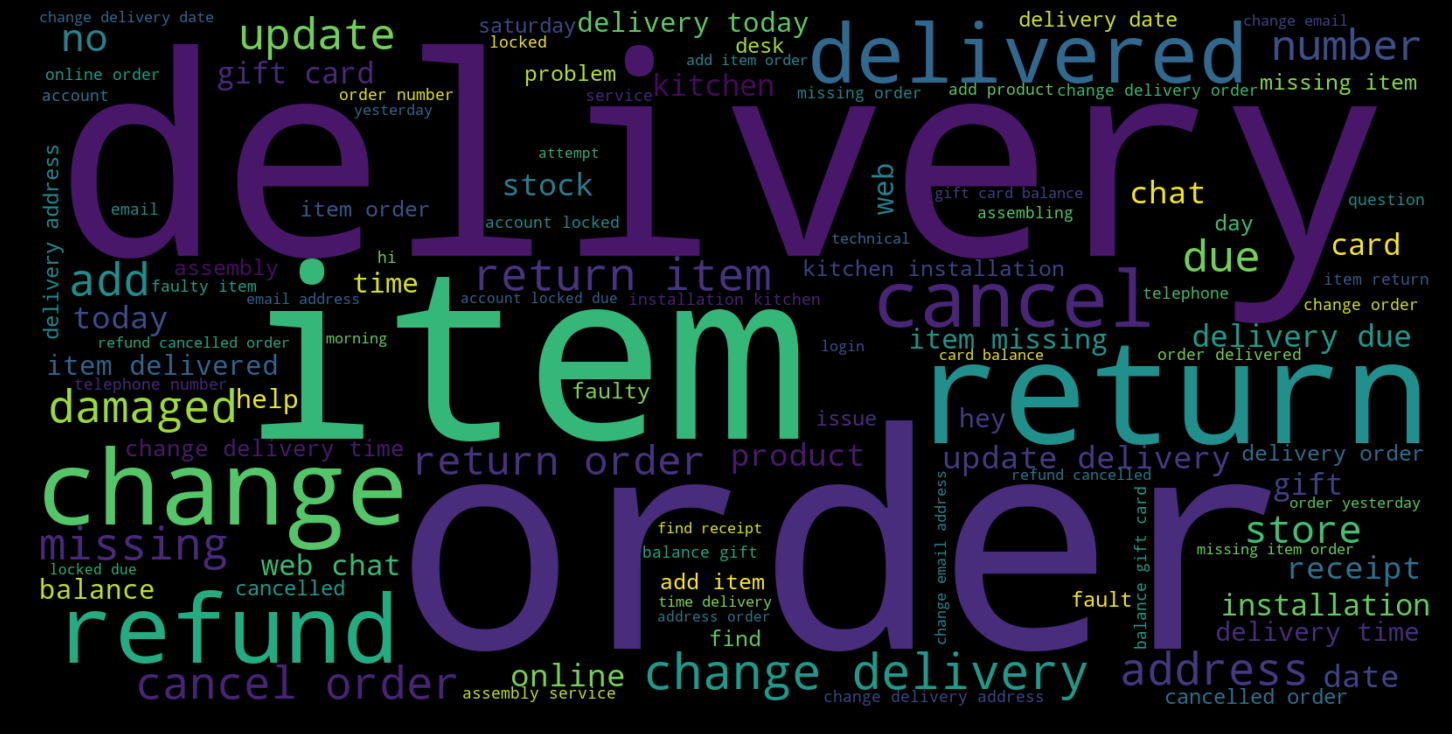

In [11]:
""" Accepts dictionary of words with it's weight and plot word cloud.

Parameters:
    weights (dict) : Dict of words with it's weight

Returns:
    Plots word cloud
"""

def create_wordcloud(weights):
    plt.figure(figsize=(20,10), facecolor='k')
    wc = WordCloud(width=1600, height=800)
    wc.generate_from_frequencies(weights)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

create_wordcloud(weights)

In [12]:
ranking.tail(10)

,term,rank
54,gift card balance,0.880730
90,refund cancelled order,0.879142
89,refund cancelled,0.879142
46,email address,0.863803
29,change email address,0.863803
28,change email,0.863803
8,address order,0.810751
69,locked due,0.773076
12,attempt,0.773076
2,account locked due,0.773076


We see that users are talking the most about order, delivery, item, return, change, refund, cancel etc but we are not sure in what context topics like order, delivery, an item is been discussed as TF-IDF doesn't account for word position and context while scoring words. <br>

We can visualize word corpus using word embeddings which are pre-trained on a neural network based on nearby context words. Pre-trained __[Glove](https://nlp.stanford.edu/projects/glove/)__ embeddings are used for this experiment.

For more information about word embeddings, you can check __[here](https://towardsdatascience.com/3-silver-bullets-of-word-embedding-in-nlp-10fa8f50cc5a)__.<br>

Note: You can use any embedding which has the highest __[word coverage](https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings)__ with respect to your data or you can train your own if you have enough data. Please note that you will get different word embeddings representation based on hyperparameters and pre-trained word vector you choose.<br>

Will use **t-SNE** which stands for t-distributed stochastic neighbor embedding a popular dimensionality reduction technique to visualize higher dimension spaces in lower dimensions (e.g. 2-D) to visualize word embedding.<br>

In [13]:
""" Accepts dictionary of words with it's weight and plot word cloud.

Parameters:
    wvs (model) : Glove word vectors
    words (list) : List of words to be considered for visualiztion.

Returns:
    Plots word embedding in 2D using t-SNE
"""

def visualize_word_embedding(words,wvs) :
         
    tsne = TSNE(n_components=2, n_iter=5000, random_state=0, perplexity=5)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(wvs)
    labels = words

    plt.figure(num=1, figsize=(10, 10)) # dpi=10, facecolor='w'
    plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
    texts = []
    for label, x, y in zip(labels, T[:, 0], T[:, 1]):
        texts.append(plt.text(x, y, label))
        #plt.annotate(label, xy=(x + 1, y + 1), xytext=(0, 0), textcoords='offset points', fontsize=10)

    adjust_text(texts, only_move={'points':'y', 'text':'y'} , arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
    plt.show()

In [14]:
import spacy

nlp = spacy.load('en')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 20000


In [15]:
unique_words = list(set([word for sublist in messages for word in sublist]))

## Considering only important top words to reduce clutter in graph
top_words = [word for word in unique_words if word in ranking["term"].values]

word_glove_vectors = np.array([nlp(word).vector for word in top_words])

In [16]:
#visualize_word_embedding(top_words, word_glove_vectors)  #Uncomment and run to see graph

For simplicity, I have considered only important words which are part of the TF-IDF list and grouped the words in clusters based on the proximity of words. I have jotted down my observations below, Feel free to use your own imagination.<br>

* Cluster 1: 
    * You can see the **order** is near to **find**. order & find might imply that finding or looking for a specific order
    * order & add & item : Adding item to an existing order
    * order & update/change : Updating or changing specific order
    * order & return : Returning order
    * order & due : Order is due
* Cluster 2 : 
    * cancel & refund & receipt : User wants to cancel the order and get a refund
* Cluster 3 : 
    * email & address, telephone & number, service :  email address and telephone number to contact customer service.
* Cluster 4 :
    * online & web & chat: a user must be talking about having an online web chat.
* Cluster 5 :
    * faulty & issue & problem : it shows issues with an item
    * question & installation : user has question about product installation
* Cluster 6 : 
    * account & login : User's account info
* Cluster 7 :
    * day + Saturday + morning etc : All date-time related words are in the same context.
<img src="Embedding.png">

You can play with TF-IDF parameters i.e max_df, min_df, ngram and try different word embedding which suits your data.<br>

Do you think you could have got similar information by manually going through each and every user message (How frustrating 😤)<br>

In the Data exploration phase, we cleaned and explored the data using various techniques like TF-IDF and word embeddings which helped to trim high and low-frequency words and use pre-trained word vectors for visualizing word corpus. We got enough information about topics of conversations. Now will move to convert text into vectors and cluster them using a popular ML algorithm.<br>

### Feature engineering 
We have to convert text into vectors so that we can input it into a clustering algorithm. <br>

You can convert text into vectors using __[word frequency](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)__, __[TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)__ or __[Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html)__ and input it to algorithm but here __[topic per document matrix](https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/)__ from LDA gave me best results based on the following reasons. You can pull this code to try it for yourself. <br>

It’s good that TF-IDF penalizes very frequent and rare words but it creates a very sparse matrix which does not work well with clustering. Check stack overflow discussion on clustering of sparse data __[here](https://stats.stackexchange.com/questions/102601/clustering-algorithms-for-extremely-sparse-data)__ and __[here](https://stats.stackexchange.com/questions/199501/user-segmentation-by-clustering-with-sparse-data)__.<br>

As word embeddings are based on a neural network, it depends on hyperparameters like window size, the number of iteration, dimensionality of the feature vectors among others which might not create right input feature because of probabilistic nature of the neural network. And, it does not consider other messages in corpus while embedding but it’s better than TF-IDF as it creates the dense vector.<br>

While in topic modeling it extracts topics from the document which can be very well used as input feature because of it not only penalizes very frequent and rare words but also consider other documents in the corpus.


In [17]:
## LDA Mallet - topic modelling algorithm is used.
## Download it from http://mallet.cs.umass.edu/download.php
os.environ['MALLET_HOME'] = "D:\Download\mallet-2.0.8\mallet-2.0.8"
mallet_path = "D:\Download\mallet-2.0.8\mallet-2.0.8\\bin\mallet"  # update this path

In [18]:
""" Create document topic matrix(LDA) which is used for feeding clustering alogrithm.

Parameters:
    model (model) : LDA model
    doc_term_matrix (array) : Doc term matrix generated from messages.

Returns:
    array : Returns document topic matrix
"""

def documentTopicMatrix (model, doc_term_matrix) :
    import operator
    from functools import reduce
    from collections import defaultdict
    import pandas as pd
    a = reduce(operator.concat, model[doc_term_matrix])
    d = defaultdict(list)
    for tup in a:
        d[tup[0]] += (tup[1],)
    df = pd.DataFrame.from_dict(d)
    doc_topic_matrix = df.values
    return doc_topic_matrix

In [19]:
""" Create document term matrix from messages where every unique term is assigned an index. 

Parameters:
    messages (list) : List of messages

Returns:
    array : Returns document term matrix
    dict : Returns dictionary
"""
def createDocTermMatrix (messages) :
    # Creating the term dictionary of our corpus, where every unique term is assigned an index.
    dictionary = corpora.Dictionary(messages)

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in messages]

    return dictionary, doc_term_matrix

In [20]:
""" Create LDA mallet model bases on  num_topics provided 

Parameters:
    messages (list) : List of messages
    num_topics (int) : Number of topics to consider while creating LDA model

Returns:
    model : Returns LDA model
    array : Returns document term matrix
    dict : Returns dictionary
"""
def createLDAMalletModel (messages, num_topics) :
    dictionary, doc_term_matrix = createDocTermMatrix(messages)
    
    ## Running and Training LDA mallet model on the document term matrix.
    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=num_topics, id2word=dictionary)

    return ldamallet, doc_term_matrix, dictionary

In [21]:
""" Create LDA model bases on  num_topics provided 

Parameters:
    messages (list) : List of messages
    num_topics (int) : Number of topics to consider while creating LDA model

Returns:
    model : Returns LDA model
    array : Returns document term matrix
    dict : Returns dictionary
"""
def createLDAModel (message, num_topics) :
    dictionary, doc_term_matrix = createDocTermMatrix(message)
    
    ## Creating the object for LDA model using gensim library
    Lda = gensim.models.ldamodel.LdaModel
    
    ## Running and Training LDA model on the document term matrix.
    ldamodel = Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=500, alpha='auto', minimum_probability=0.0)

    return ldamodel, doc_term_matrix, dictionary

__[Coherence score](https://rare-technologies.com/what-is-topic-coherence/)__ is used to decide best number of topics which provide a convenient measure to judge how good a given topic model is.

In [22]:
""" Compute coherence score of topic model

Parameters:
    model (model) : Topic model
    texts (list) : List of message
    dictionary (dict) : Word dictionary

Returns:
    int : Coherence values corresponding to the LDA model with respective number of topics
"""
def computeCoherenceModel (model, texts, dictionary) :

    coherence_model_lda = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    
    return coherence_lda

In [23]:
""" Compute optimal number of topics based on coherence score

Parameters:
    texts (list) : List of input texts
    limit (int) : Max number of topics to check.
    modelName (str) : Topic model to use
    start (int) [Default:2] : Minimum value for number of topics
    step (int) [Default:1] : steps to increment for iterating topics 

Returns:
    int : Returns optimal topic number based on max coherence score
"""
def computeOptimalNumTopics (texts, limit, modelName = 'LDAMallet', start=2, step=1):
    from operator import itemgetter
    coherence_values = []
    for num_topics in tqdm(range(start, limit, step)):
        if (modelName == 'LDA') :
            model, doc_term_matrix, dictionary = createLDAModel(texts, num_topics)
        elif (modelName == 'LDAMallet'):
            model, doc_term_matrix, dictionary = createLDAMalletModel(texts, num_topics)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    # Show graph
    x = range(start, limit, step)
    max_num_topic = max(zip(coherence_values,list(x)),key=itemgetter(0))[1]
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    return max_num_topic

__[Silhouette score](http://bit.ly/2Qu4U6A)__ is used to find optimum number of k(cluster). Alternatively you can use __[Elbow method](http://bit.ly/2LVBqOj)__ as well.

In [24]:
""" K means clustering algorithm implementation

Parameters:
    n_cluster (int) : Number of cluster to consider for algorithm.
    doc_topic_matrix (array) : doc topic matrix generated from word dictionary

Returns:
    int : Returns silhouette score and sum of squared distance
"""
def kMeans(n_cluster, doc_topic_matrix) :
    from sklearn.metrics import silhouette_score
    km = KMeans(n_clusters=n_cluster)
    pred = km.fit_predict(doc_topic_matrix)
    # Sum_of_squared_distances.append(km.inertia_)
    score = silhouette_score(doc_topic_matrix, pred, metric='euclidean')
    sum_of_squared_distance = km.inertia_

    return score, sum_of_squared_distance

In [25]:
""" To find optimum number of clusters

Parameters:
    messages (list) : List of input texts
    num_topics (int) : Number of topics for LDA model
    limit (int) : Maximum number of clusters to check.
    modelName (str) : Topic model to use
    start (int) [Default:2] : Minimum value for number of clusters

Returns:
    int : Returns optimal cluster number based on max silhouette score
"""

def OptimalK(messages, num_topics, limit, modelName = 'LDAMallet', start = 2) :
    from operator import itemgetter
    
    if (modelName == 'LDA'):
        model, doc_term_matrix, dictionary = createLDAModel(messages, num_topics)
    elif (modelName == 'LDAMallet'):
        model, doc_term_matrix, dictionary = createLDAMalletModel(messages, num_topics)

    doc_topic_matrix = documentTopicMatrix(model, doc_term_matrix)
    Sum_of_squared_distances = []
    silhouette_score_list = []
    K = range(start, limit)
    
    for k in tqdm(K) : 
        score, sum_of_squared_distance = kMeans(k,doc_topic_matrix)
        silhouette_score_list.append(score)
        Sum_of_squared_distances.append(sum_of_squared_distance)
        
    max_num_cluster = max(zip(silhouette_score_list,list(K)),key=itemgetter(0))[1]
    plt.plot(K, silhouette_score_list, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette_score for optimal k')
    plt.show()
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow_method for optimal k')
    plt.show()

    return max_num_cluster

### Message clustering

Now let's get to what we are here for: data tagging. <br>


__[K means](https://www.coursera.org/lecture/machine-learning/k-means-algorithm-93VPG)__ is used for clustering because it is probably the most well-known algorithm and it’s very easy to implement in Python. There are plenty of other clustering algorithms out there. You can check this __[amazing article](https://towardsdatascience.com/the-5-clustering-algorithms-data-scientists-need-to-know-a36d136ef68)__ and try different clustering algorithms. Feel free to let me know your results in the comment box of an article.

In [26]:
""" Clustering based on optimum number of clusters.

Parameters:
    messages (list) : List of input texts
    actual_messages (list) : List of original input texts(without cleaning)
    num_topics (int) : Number of topics for LDA model
    n_clusters (int) : Number of topics for K means
    modelName (str) : Topic model to use
    intentName (list) : List of intents corresponding to its message.

Returns:
    list : Returns list of clustered messages
"""

def kmeansClustering (messages, actual_messages, intentName, num_topics, n_clusters, modelName = 'LDAMallet') :

    if (modelName == 'LDA'):
        model, doc_term_matrix, dictionary = createLDAModel(messages, num_topics)
    elif (modelName == 'LDAMallet'):
        model, doc_term_matrix, dictionary = createLDAMalletModel(messages, num_topics)
        
    doc_topic_matrix = documentTopicMatrix(model, doc_term_matrix)

    km = KMeans(n_clusters=n_clusters)
    km.fit(doc_topic_matrix)
    clustered_Message = zipClusterMessages(km, actual_messages, intentName)
    return clustered_Message

In [27]:
""" zip clustered messages with it's cluster numbers and intent names.

Parameters:
    km (model) : K means model
    actual_messages (list) : List of original input texts(without cleaning)
    intentName (list) : List of intents corresponding to its message.

Returns:
    list : Returns list of clustered messages
"""
def zipClusterMessages (km, actual_messages, intentName) :
    clustered_Message = []
    # Get cluster assignment labels
    clusters = km.labels_.tolist()
    for i in sorted(zip(clusters, map(str, actual_messages), intentName)):
        clustered_Message.append(i)
    return clustered_Message

In [28]:
""" Saves clustered messages to excel file

Parameters:
    file_name (str) : File name
    clustered_Message (list) : Clustered messages

Returns:

"""
def saveClusteredMessagetToExcel (file_name, clustered_Message) :
    # Create a workbook and add a worksheet.
    workbook = xlsxwriter.Workbook(file_name)
    worksheet = workbook.add_worksheet("clustered")

    # Iterate over the data and write it out row by row.
    for row, line in enumerate(clustered_Message):
        for col, cell in enumerate(line):
            worksheet.write(row, col, cell)

    workbook.close()

In [29]:
""" Main function to find optimal number of topic and cluster and create clustered messages.

Parameters:
    file_name (str) : File name
    startNumTopics (int) : Minimum value for number of topic
    limitNumTopics (int) : Maximum value for number of topic
    startNumCluster (int) : Minimum value for number of cluster
    limitNumCluster (int) : Maximum value for number of cluster

Returns:

"""
def main(file_name, startNumTopics, limitNumTopics, startNumCluster, limitNumCluster) :
    print("Calculating best number of topics...")
    num_topics = computeOptimalNumTopics(texts=messages, start=startNumTopics, limit=limitNumTopics)
    print("Best number of topics are ", num_topics)
    print("Calculating best number of clusters...")
    n_clusters = OptimalK(messages= messages, num_topics=num_topics , start=startNumCluster, limit=limitNumCluster)
    print("Best number of clusters are ", n_clusters)
    clustered_Message = kmeansClustering(messages, df['Message'].tolist(), intent, num_topics, n_clusters, "LDAMallet")
    saveClusteredMessagetToExcel(file_name, clustered_Message)

Calculating best number of topics...


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [12:36<00:00, 42.04s/it]


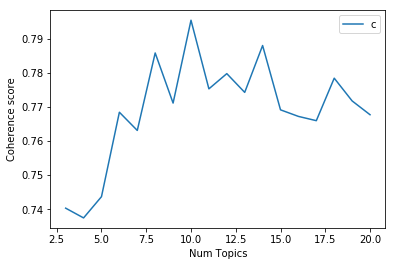

Best number of topics are  10
Calculating best number of clusters...


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 12.68it/s]


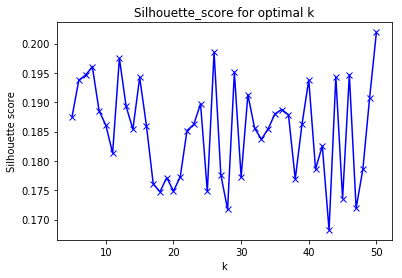

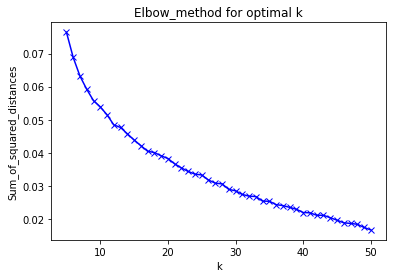

Best number of clusters are  50
Finished in  829.5759274959564


In [30]:
output_file_name = "output_1.xlsx"
startNumberTopics = 3
limitNumberTopics = 20 + 1
startNumberCluster = 5
limitNumberCluster = 50 + 1
start = time.time()  # Start time
main(output_file_name, startNumberTopics, limitNumberTopics, startNumberCluster, limitNumberCluster)
end = time.time() # End time
print("Finished in ", end-start)

I have used a small hack to remove noise from the data. There are unique numbers, alphanumeric characters that will not be part of word embedding. Also, each such tokens are considered as the separate feature which is irrelevant to an algorithm.
Let's see if we can identify them and replace some pattern with a unique token.

In [31]:
non_alpha = [word for message in messages for word in message if not word.isalpha()]

We identified 6 digit numbers, 6 digit numbers separated by period, dates and times etc.
Replace them with a unique token like 6 digit number to number_1, number separated by a period to number_period and remove others.

In [32]:
print(non_alpha)

['974633', 'damaged/faulty', 'b46', '1nr', '801.552', '365', '975355', '', '295718', '', '45', '10-3pm', '2018-07-01', '003.923', '', '972009', 'x2', '', '302.990', '', '', '296825', '', '976976', '', '976867', '11-3', '967536', '977078', '', '803222', '978627', '977534', '', '986953', '', '', '3-7pm', '3rd', '102', '578', '7-11am', '803.453', '977126', '', '972547', '']


In [33]:
number_period = re.compile(r"\b\d{3}[\.|\s|-]?\d{3}\b")
number_1 = re.compile(r"\b\d{3}[\.|\s|-]?\d{3}\b")
regexDict = {"number_period" : number_period , "number_1" : number_1}

In [34]:
def clean_text_advance(doc) :
    for key, value in regexDict.items() :
        doc = value.sub(key, doc)
    token = clean_text(doc)
    return token

In [35]:
messages = df['Message'].progress_apply(lambda x: clean_text_advance(x))

100%|██████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 7832.24it/s]


Calculating best number of topics...


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [12:01<00:00, 40.07s/it]


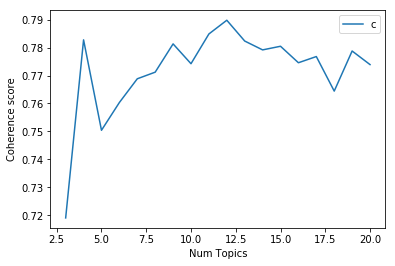

Best number of topics are  12
Calculating best number of clusters...


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:03<00:00, 13.10it/s]


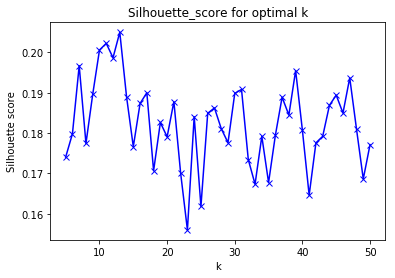

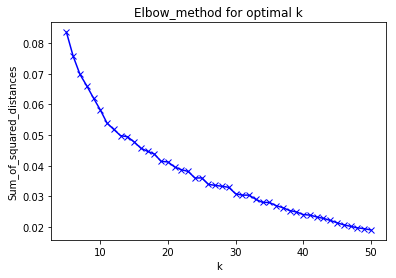

Best number of clusters are  13
Finished in  793.0207979679108


In [36]:
output_file_name = "output_2.xlsx"
startNumberTopics = 3
limitNumberTopics = 20 + 1
startNumberCluster = 5
limitNumberCluster = 50 + 1
start = time.time()  # Start time
main(output_file_name, startNumberTopics, limitNumberTopics, startNumberCluster, limitNumberCluster)
end = time.time()
print("Finished in ", end-start)

BOOM, we have the result and it has already reduced most of the manual work by clustering similar utterances together. We can quickly skim it and tag it to its respective intent, as we already know the topics that we have explored in the data exploration step.

Let’s check out few clusters,


<img src="cluster.png">

You can visualize the topics by using pyLDAvis. <br>

Note: It is buggy with LDA Mallet. Check __[here](https://github.com/RaRe-Technologies/gensim/issues/1203)__ for more information. So used LDA for now.

In [37]:
def topicVisulization (messages, num_topics, n_clusters, modelName='LDAMallet') :

    if (modelName == 'LDA'):
        model, doc_term_matrix, dictionary = createLDAModel(messages, num_topics)
    elif (modelName == 'LDAMallet'):
        mallet_model, doc_term_matrix, dictionary = createLDAMalletModel(messages, num_topics)
        model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model)

    # Visualize the topics
    vis = pyLDAvis.gensim.prepare(model, doc_term_matrix, dictionary)
    #pyLDAvis.display(vis)  ## Issue with the display: https://github.com/bmabey/pyLDAvis/issues/101
    pyLDAvis.save_html(vis, 'LDA_Visualization.html')

In [38]:
topicVisulization(messages = messages, num_topics = 8, n_clusters = 47, modelName = 'LDA')